In [80]:
from fastai.data.external import untar_data, URLs

path = untar_data(URLs.MNIST_SAMPLE)


In [81]:
from fastcore.xtras import Path

Path.BASE_PATH = path


In [82]:
path.ls()


(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [83]:
(path/'train').ls()


(#2) [Path('train/7'),Path('train/3')]

In [84]:
three_paths = (path/'train'/'3').ls().sorted()
seven_paths = (path/'train'/'7').ls().sorted()
three_paths


(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [85]:
from PIL import Image

im3_path = three_paths[1]
im3 = Image.open(im3_path)
im3


In [86]:
from numpy import array

array(im3)[4:10,4:10]


array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [87]:
from fastai.torch_core import tensor

tensor(im3)[4:10,4:10]


tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [88]:
import pandas as pd

df = pd.DataFrame(tensor(im3)[4:15,4:22])
df.style.set_properties(**{'font-size': '6pt'}).background_gradient('Greys')


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [89]:
seven_tensors = [tensor(Image.open(o)) for o in seven_paths]
three_tensors = [tensor(Image.open(o)) for o in three_paths]
len(three_tensors),len(seven_tensors)


(6131, 6265)

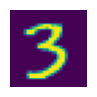

In [90]:
from fastai.torch_core import show_image

show_image(three_tensors[1]);


In [91]:
import torch

train_stacked_7s = torch.stack(seven_tensors).float()/255
train_stacked_3s = torch.stack(three_tensors).float()/255
train_stacked_3s.shape


torch.Size([6131, 28, 28])

In [92]:
# ==
len(train_stacked_3s.shape),train_stacked_3s.ndim


(3, 3)

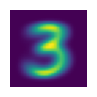

In [93]:
mean3 = train_stacked_3s.mean(0)
mean3.ndim # 2
show_image(mean3);


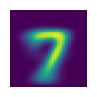

In [94]:
mean7 = train_stacked_7s.mean(0)
show_image(mean7);


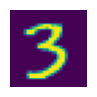

In [95]:
a_3 = train_stacked_3s[1]
show_image(a_3);


In [96]:
dist_3_abs = (a_3 - mean3).abs().mean() # L1 norm aka mean absolute difference
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt() # L2 norm aka root mean squared error aka RMSE - penalizes bigger mistakes, more lenient with small mistakes
dist_3_abs,dist_3_sqr


(tensor(0.1114), tensor(0.2021))

In [97]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr


(tensor(0.1586), tensor(0.3021))

In [98]:
import torch.nn.functional as F

F.l1_loss(a_3,mean3),F.l1_loss(a_3,mean7)


(tensor(0.1114), tensor(0.1586))

In [99]:
F.mse_loss(a_3,mean3).sqrt(),F.mse_loss(a_3,mean7).sqrt()


(tensor(0.2021), tensor(0.3021))

### Numpy Arrays and PyTorch Tensors

In [100]:
data = [[1,2,3],[4,5,6]]
arr = array(data)
arr, arr.__class__


(array([[1, 2, 3],
        [4, 5, 6]]),
 numpy.ndarray)

In [101]:
tns = tensor(data)
tns, tns.__class__


(tensor([[1, 2, 3],
         [4, 5, 6]]),
 torch.Tensor)

In [102]:
tns.type()


'torch.LongTensor'

In [103]:
tns2 = tns/2
tns2.type()


'torch.FloatTensor'

## Computing Metrics Using Broadcasting
### Checking the baseline model for 3s and 7s

In [104]:
valid_stacked_3s = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_stacked_3s = valid_stacked_3s.float()/255
valid_stacked_7s = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_stacked_7s = valid_stacked_7s.float()/255

valid_stacked_3s.shape, valid_stacked_7s.shape


(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [105]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))

mnist_distance(a_3, mean3)


tensor(0.1114)

In [106]:
valid_3_dist = mnist_distance(valid_stacked_3s, mean3)
valid_3_dist, valid_3_dist.shape


(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

In [107]:
res = valid_stacked_3s - mean3
print(res.shape)
res.abs().mean((-1,-2))


torch.Size([1010, 28, 28])


tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640])

In [108]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)


In [109]:
is_3(a_3), is_3(a_3).float()


(tensor(True), tensor(1.))

In [110]:
is_3(valid_stacked_3s)


tensor([True, True, True,  ..., True, True, True])

In [111]:
is_3(valid_stacked_3s)


tensor([True, True, True,  ..., True, True, True])

In [112]:
accuracy_3s =      is_3(valid_stacked_3s).float() .mean()
accuracy_7s = (1 - is_3(valid_stacked_7s).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2, (tensor(accuracy_3s, accuracy_7s)).mean()


(tensor(0.9168), tensor(0.9854), tensor(0.9511), tensor(0.9511))

## Stochastic Gradient Descent

In [113]:
def f(x): return x**2


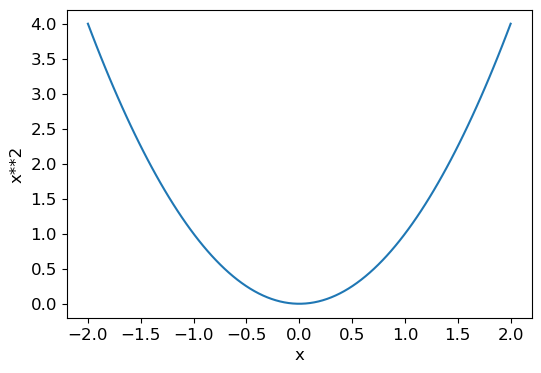

In [114]:
from fastbook import plot_function

plot_function(f, 'x', 'x**2')


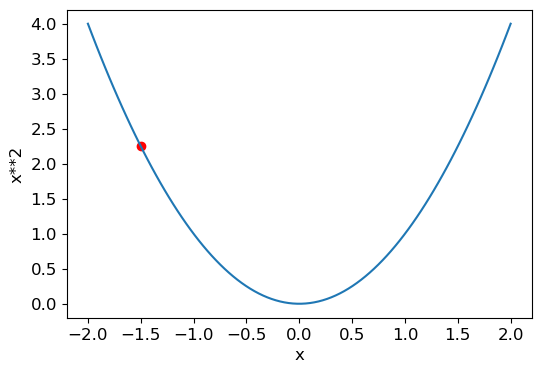

In [115]:
from matplotlib import pyplot as plt

plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');


In [116]:
xt = tensor(3.).requires_grad_()


In [117]:
yt = f(xt)
yt


tensor(9., grad_fn=<PowBackward0>)

In [118]:
yt.backward()


In [119]:
xt.grad


tensor(6.)

In [120]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt


tensor([ 3.,  4., 10.], requires_grad=True)

In [121]:
def f(x): return (x**2).sum()

yt = f(xt)
yt


tensor(125., grad_fn=<SumBackward0>)

In [122]:
yt.backward()
xt.grad


tensor([ 6.,  8., 20.])

## End-to-end SGD example

In [123]:
time = torch.arange(0,20); time


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [124]:
# this actually looks much better without the "time-9.5"
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1


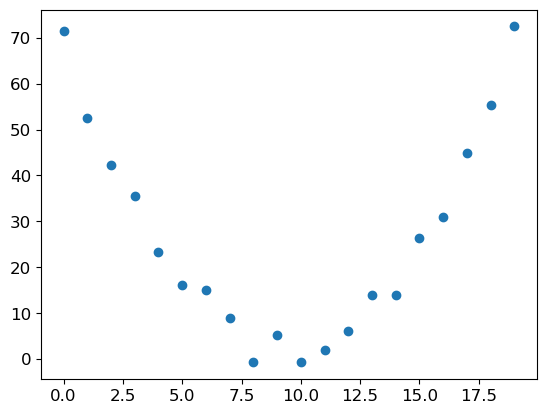

In [125]:
plt.scatter(time,speed);


In [126]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c


In [127]:
def mse(preds, targets): return ((preds-targets)**2).mean()  # for continuous data (like this), it's common to use mse


#### 1 - initialize the parameters

In [128]:
params = torch.randn(3).requires_grad_()
print(params)
orig_params = params.clone()


tensor([-0.6467, -0.5207,  1.1711], requires_grad=True)


#### 2 - calculate the predictions

In [129]:
preds = f(time, params)


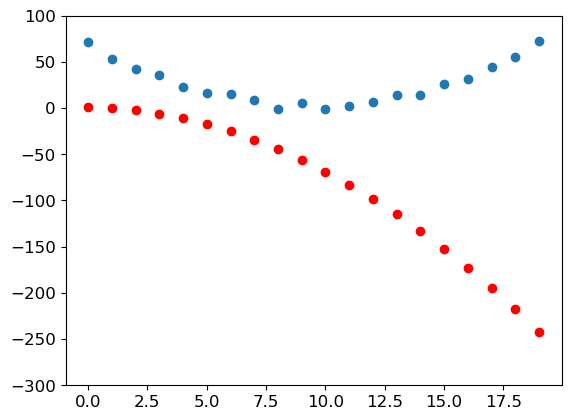

In [130]:
from fastai.torch_core import to_np

def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)
show_preds(preds)


#### 3 - calculate the loss

In [131]:
loss = mse(preds, speed); loss


tensor(19401.6758, grad_fn=<MeanBackward0>)

#### 4 - calculate the gradients

In [132]:
loss.backward()
params.grad


tensor([-45952.6406,  -2951.4680,   -220.8227])

In [133]:
params


tensor([-0.6467, -0.5207,  1.1711], requires_grad=True)

#### 5 - step the weights

In [134]:
lr = 1e-5
params.data -= lr * params.grad
params.grad = None

params


tensor([-0.1871, -0.4912,  1.1733], requires_grad=True)

In [135]:
preds = f(time,params)
mse(preds, speed)


tensor(4187.6997, grad_fn=<MeanBackward0>)

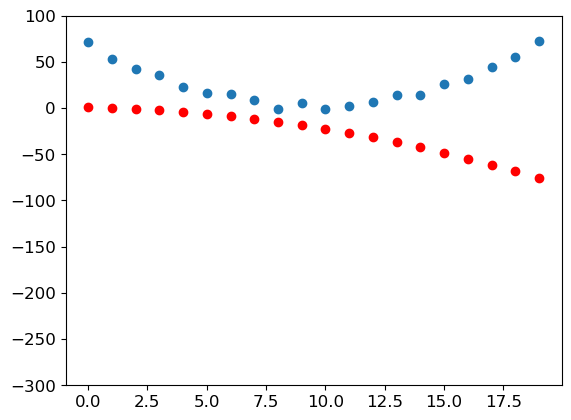

In [136]:
show_preds(preds)


In [137]:
def apply_step(params, prn=True):
    preds = f(time, params) # 2 - calculate predictions
    loss = mse(preds, speed) # 3 - calculate loss
    loss.backward() # 4 - calculate gradients
    params.data -= lr * params.grad.data # 5 - step weights
    params.grad = None
    if prn: print(loss.item())
    return preds


#### 6 - repeat the process

In [138]:
for i in range(10): apply_step(params)


4187.69970703125
1308.7464599609375
763.9578857421875
660.8641967773438
641.3527221679688
637.6576538085938
636.9554443359375
636.819580078125
636.7908935546875
636.7825317382812


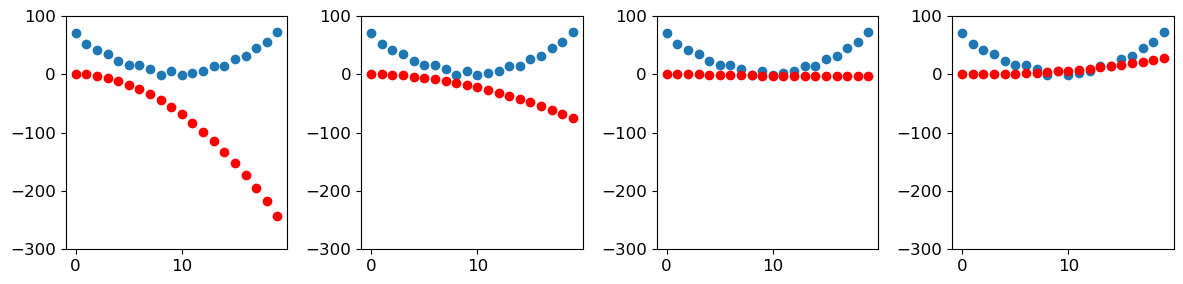

In [139]:
params = orig_params.detach().requires_grad_()

_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()


#### 7 - stop

## The MNIST Loss Function

In [140]:
train_x = torch.cat([train_stacked_3s, train_stacked_7s]).view(-1,28*28)
train_x.shape


torch.Size([12396, 784])

In [141]:
train_y = tensor([1]*len(three_paths) + [0]*len(seven_paths)).unsqueeze(1)
train_x.shape, train_y.shape


(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [142]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape, y


(torch.Size([784]), tensor([1]))

In [143]:
valid_x = torch.cat([valid_stacked_3s, valid_stacked_7s]).view(-1,28*28)
valid_y = tensor([1]*len(valid_stacked_3s) + [0]*len(valid_stacked_7s)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))
valid_x,valid_y = valid_dset[0]
valid_x.shape, valid_y


(torch.Size([784]), tensor([1]))

In [144]:
# 1 - initialize
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()


In [145]:
# one for every pixel
weights = init_params((28*28,1))
print(weights.shape)
weights.data


torch.Size([784, 1])


tensor([[ 1.6714e+00],
        [-4.9412e-01],
        [ 9.5992e-01],
        [ 5.8009e-01],
        [-1.0223e+00],
        [-7.0839e-01],
        [ 5.9592e-02],
        [-6.8633e-01],
        [ 6.5447e-01],
        [-1.4683e-01],
        [ 1.4138e+00],
        [-5.8905e-01],
        [-5.8013e-01],
        [ 7.4109e-01],
        [ 1.8646e+00],
        [-1.3074e+00],
        [-4.0066e-01],
        [-1.5425e+00],
        [ 1.1432e+00],
        [ 1.3563e+00],
        [-1.2485e+00],
        [-2.5727e-02],
        [ 1.9367e+00],
        [-9.1970e-01],
        [ 5.3585e-01],
        [ 5.4134e-01],
        [-1.2874e+00],
        [-1.2039e+00],
        [-6.5810e-01],
        [-3.5780e-01],
        [ 4.2016e-01],
        [-6.8256e-03],
        [-3.1888e-01],
        [-4.9083e-01],
        [-4.8581e-01],
        [-4.9008e-01],
        [ 9.2064e-01],
        [-6.2857e-01],
        [ 6.6634e-01],
        [-3.5470e-02],
        [-1.3073e-01],
        [-1.4062e+00],
        [ 2.7282e-01],
        [ 7

In [146]:
bias = init_params(1)
bias


tensor([-0.6479], requires_grad=True)

In [147]:
# prediction for 1 image
(train_x[0]*weights.T).sum() + bias


tensor([3.5762], grad_fn=<AddBackward0>)

In [148]:
(train_x.shape, weights.shape)


(torch.Size([12396, 784]), torch.Size([784, 1]))

In [149]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds


tensor([[  3.5762],
        [ -3.7747],
        [ -7.1949],
        ...,
        [-17.4559],
        [ -5.3980],
        [-10.8374]], grad_fn=<AddBackward0>)

In [150]:
corrects = (preds>0.0).float() == train_y
corrects.float().mean().item()


0.6364956498146057

In [151]:
with torch.no_grad(): weights[0] *= 1.0001
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()
# small change to weights yields no change in accuracy


0.6364956498146057

## Sigmoid

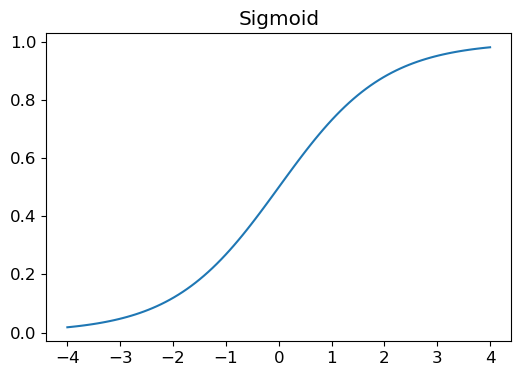

In [152]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)


In [153]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()


### Putting It All Together

In [154]:
from fastai.data.load import DataLoader

# initialize parameters
weights = init_params((28*28,1))
bias = init_params(1)

weights.shape, bias.shape


(torch.Size([784, 1]), torch.Size([1]))

In [155]:
# from fastcore.basics import first

# create dataloaders
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)


In [156]:
# test with mini-batch of size 4
preds = linear1(train_x[:4])
display(preds)
loss = mnist_loss(preds, train_y[:4])
display(loss)
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

# NOTE HERE


tensor([[-7.1094],
        [-3.4319],
        [-7.7986],
        [-6.1509]], grad_fn=<AddBackward0>)

tensor(0.9913, grad_fn=<MeanBackward0>)

(torch.Size([784, 1]), tensor(-0.0012), tensor([-0.0084]))

In [157]:
train_y[:4]


tensor([[1],
        [1],
        [1],
        [1]])

In [158]:
# putting it into a fn
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()

calc_grad(train_x[:4], train_y[:4], linear1)
weights.grad.mean(), bias.grad


(tensor(-0.0024), tensor([-0.0168]))

In [159]:
calc_grad(train_x[:4], train_y[:4], linear1)
weights.grad.mean(),bias.grad


(tensor(-0.0037), tensor([-0.0253]))

In [160]:
calc_grad(train_x[:4], train_y[:4], linear1)
weights.grad.mean(),bias.grad


(tensor(-0.0049), tensor([-0.0337]))